In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import tensorly as tl
tl.set_backend("pytorch")
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor
from scipy.linalg import khatri_rao

In [21]:
class CP_ALS():
    """
    This class computes the Candecomp PARAFAC decomposition using 
    N-way Alternating least squares algorithm along with khatri rao product
    """
    def moveaxis(self, tensor, source, destination):
        """
        This method is from the implementation given in pytorch https://github.com/pytorch/pytorch/issues/36048#issuecomment-652786245
        Input : 
            tensor : Input tensor
            source : First axis to move
            destination : Second axis to replace the first one
        Output :
            Output tensor to where the axis is moved
        """
        dim = tensor.dim()
        perm = list(range(dim))
        if destination < 0:
            destination += dim
        perm.pop(source)
        perm.insert(destination, source)
        return tensor.permute(*perm)
    
    def unfold_tensor(self, tensor, mode):
        """ This method unfolds the given input tensor along with the specified mode.
        Input :
            tensor : Input tensor
            mode : Specified mode of unfolding
        Output :
            matrix : Unfolded matrix of the tensor with specified mode
        """
        t = self.moveaxis(tensor, mode, 0)
        matrix = t.reshape(tensor.shape[mode], -1)
        return matrix
    
    #def perform_Kronecker_Product(self, t1, t2):
    #    t1_flatten = torch.flatten(t1)
    #    op = torch.empty((0, ))
    #    for element in t1_flatten:
    #        output = element*t2
    #        op = torch.cat((op, output))
    #    return op
    
    #def perform_Khatri_Rao_Product(self, t1, t2):
    #    # Check for criteria if the columns of both matrices are same
    #    r1, c1 = t1.shape
    #    r2, c2 = t2.shape
    #    if c1 != c2:
    #        print("Number of columns are different. Product can't be performed")
    #        return 0
    #    opt = torch.empty((r1*r2, c1))
    #    for col_no in range(0, t1.shape[-1]):
    #        x = self.perform_Kronecker_Product(t1[:, col_no], t2[:, col_no])
    #        opt[:, col_no] = x
    #    return opt

    def perform_Kronecker_Product(self, A, B):
        """ 
        This method performs the kronecker product of the two matrices
        The method is adaption of the method proposed in https://discuss.pytorch.org/t/kronecker-product/3919/10
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            Output is the resultant matrix after kronecker product
        """
        return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))
    
    def perform_Khatri_Rao_Product(self, A, B):
        """
        This methods performs the Khatri Rao product as it is the column wise kronecker product
        Input : 
            A : Input matrix 1
            B : Input matrix 2
        Output : 
            result : The resultant Khatri-Rao product matrix
        """
        if A.shape[1] != B.shape[1]:
            print("Inputs must have same number of columns")
            return 0
        result = None
        for col in range(A.shape[1]):
            res = self.perform_Kronecker_Product(A[:, col].unsqueeze(0), B[:, col].unsqueeze(0))
            if col == 0:
                result = res
            else:
                result = torch.cat((result, res), dim = 0)
        return result.T

    def compute_MTTKRP(self, tensor_matrix, A, k_value):
        """
        This method computes the Matricized Tensor Times Khatri-Rao product
        between the unfolded tensor and the all other factors apart from kth factor.
        Input : 
            tensor_matrix : Unfolded tensor as a matrix
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            B : Resultant MTTKRP matrix
        """
        #A_matrix = copy.deepcopy(A)
        #A_matrix.pop(k_value)
        krp_matrix = A[0]
        for index in range(1, len(A)):
            krp_matrix = self.perform_Khatri_Rao_Product(krp_matrix, A[index])
        B = torch.matmul(tensor_matrix, krp_matrix)
        return B
    
    def compute_fit(self, X, M):
        diff = X-M
        fit = (np.linalg.norm(diff))/(np.linalg.norm(X))
        return fit
    
    def compute_V_Matrix(self, A, k_value):
        """
        This method computes the V value as a hadamard product of 
        outer product of every factort matrix apart from kth factor matrix.
        Input : 
            A : Factor matrices
            k_value : index of kth matrix to be excluded
        Output : 
            v : Resultant V matrix after the hadamard product
        """
        #A_matrix = copy.deepcopy(A)
        #A_matrix.pop(k_value)
        v = torch.matmul(A[0].T, A[0])
        for index in range(1, len(A)):
            p = torch.matmul(A[index].T, A[index])
            v = v*p
        return v
    
    def create_A_Matrix(self, tensor_shape, rank):
        """
        This method generates required number of factor matrices.
        Input : 
            tensor_shape : shape of the input tensor
            rank : Required rank of the factors
        Output : 
            A : Resultant list of factor matrices
        """
        A = []
        for i in tensor_shape:
            A.append(torch.randn((i, rank)))
        return A
    
    def compute_ALS(self, input_tensor, max_iter, rank):
        """
        This method is heart of this algorithm, this computes the factors and also lambdas of the algorithm.
        Input : 
            input_tensor : Tensor containing input values
            max_iter : maximum number of iterations
            rank : prescribed rank of the resultant factors
        Output : 
            A : factor matrices
            lmbds : column norms of each factor matrices
        """
        A = self.create_A_Matrix(input_tensor.shape, rank)
        lmbds = []
        fit_list = []
        for l_iter in range(0, max_iter):
            for k in range(0, len(A)):
                X_unfolded = self.unfold_tensor(input_tensor, k)
                A.pop(k)
                Z = self.compute_MTTKRP(X_unfolded, A, k)
                V = self.compute_V_Matrix(A, k)
                A_k = torch.matmul(Z, torch.pinverse(V))
                #l = torch.norm(A_k, dim=0)
                #d_l = np.zeros((rank, rank))
                #np.fill_diagonal(d_l, l)
                #A_k = np.dot(A_k, np.linalg.pinv(d_l))
                #if l_iter == 0:
                #    lmbds.append(np.linalg.norm(l))
                #else:
                #    lmbds[k] = np.linalg.norm(l)
                #A[k] = A_k
                A.insert(k, A_k)
            if l_iter%5 == 0:
                M = self.reconst(A, input_tensor.shape)
                fit_val = self.compute_fit(input_tensor, M)
                fit_list.append([l_iter, fit_val])
        return A, lmbds, fit_list
    
    def reconstruct_tensor(self, factors, norm, rank, ip_shape):
        """
        This method reconstructs the tensor given factor matrices and norms
        Input : 
            factors : factor matrices
            norm : column norms of every factor matrices
            rank : prescribed rank of the resultant factors
            ip_shape : Input tensor shape 
        Output : 
            M : Reconstructed tensor
        """
        M = 0       
        for c in range(0, rank):
            op = factors[0][:, c]
            for i in range(1, len(factors)):
                op = np.outer(op.T, factors[i][:, c])
            M += op
        M = np.reshape(M, ip_shape)
        return M

    def reconstruct_Three_Way_Tensor(self, a, b, c):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

    def reconst(self, A, ip_shape):
        k_Rao = tl.tenalg.khatri_rao(A, skip_matrix=0)
        #print(k_Rao.shape)
        tensor = torch.matmul(A[0], tl.tenalg.khatri_rao(A, skip_matrix=0).T)
        return tl.fold(tensor, 0, ip_shape)
    # Reconstruct the tensor from the factors
    def reconstruct_Four_Way_Tensor(self, a, b, c, d):
        """This method reconstructs the tensor from the rank one factor matrices
        Inputs: 
            a : First factor in CP decomposition
            b : Second factor in CP decomposition
            c : Third factor in CP decomposition
            d : Fourth factor in CP decomposition
        Output:
            x_t : Reconstructed output tensor"""

        x_t = 0
        #row, col = a.shape()
        for index in range(a.shape[1]):
            Y = (torch.ger(a[:, index], b[:, index]).unsqueeze(2)*c[:, index]).unsqueeze(3)*d[:,index].unsqueeze(0).unsqueeze(0)
            x_t += Y
            #x_t += torch.ger(a[:,index], b[:,index]).unsqueeze(2)*c[:,index].unsqueeze(0).unsqueeze(0)
        return x_t

In [22]:
rank = [45, 100, 140, 200, 250, 300]
max_iter = 100
als = CP_ALS()

In [23]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
second_weight_tensor = AlexNet_model.features[3].weight.data
print("Second weight tensor shape is: ")
print(second_weight_tensor.shape)

Using cache found in /home/lveeramacheneni/.cache/torch/hub/pytorch_vision_v0.6.0


Second weight tensor shape is: 
torch.Size([192, 64, 5, 5])


In [26]:
A, lmbds, f_list = als.compute_ALS(second_weight_tensor, max_iter, 45)

In [27]:
print(f_list)

[[0, 0.896509], [5, 0.7308813], [10, 0.7191597], [15, 0.71423995], [20, 0.7116985], [25, 0.70999223], [30, 0.70858455], [35, 0.70737356], [40, 0.70638084], [45, 0.7055919], [50, 0.7049701], [55, 0.7044757], [60, 0.70407456], [65, 0.70374054], [70, 0.7034548], [75, 0.7032048], [80, 0.70298135], [85, 0.7027782], [90, 0.70259094], [95, 0.7024164]]


In [29]:
r = [4, 45, 140]
f_l = []
for index in range(len(r)):
    print("Rank : ", r[index])
    _, _, f = als.compute_ALS(second_weight_tensor, max_iter, r[index])
    f_l.append(f)

Rank :  4
Rank :  45
Rank :  140


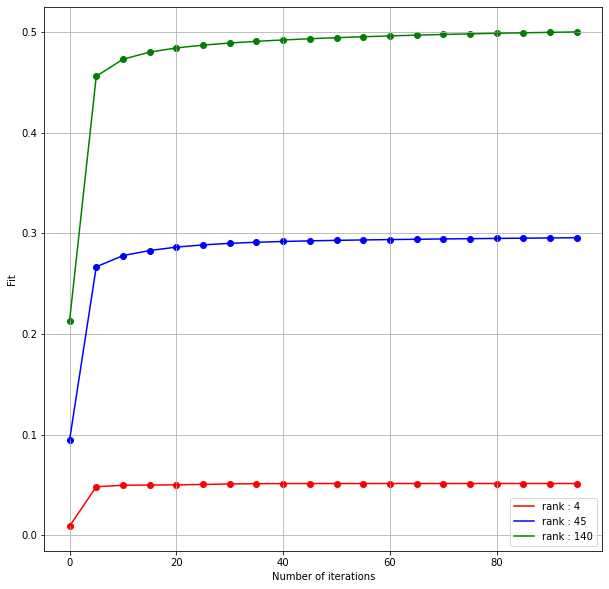

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = ['r', 'b', 'g', 'k', 'm', 'c']
precent = []
for index, f_list in enumerate(f_l):
    x = []
    y = []
    clr = colors[index]
    for i in f_list:
        plt.scatter(i[0], 1-i[1], c=clr)
        x.append(i[0])
        y.append(1-i[1])
    lbl = "rank : "+str(r[index])
    plt.plot(x, y, c=clr, label = lbl)
    precent.append(f_list[-1][-1])
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Fit")
plt.grid()
plt.show()

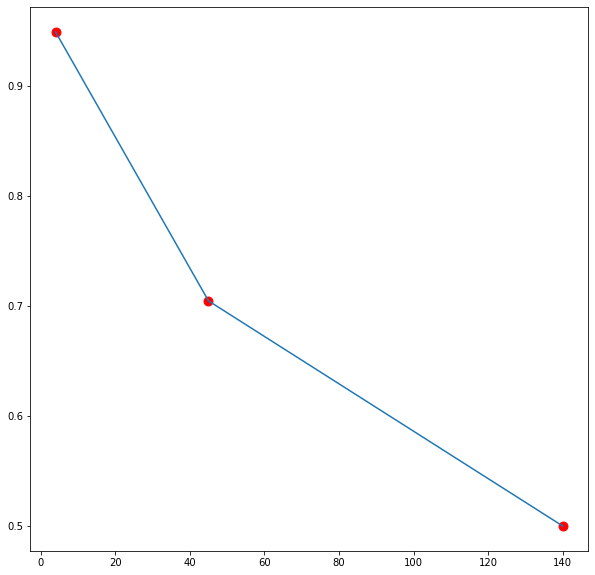

In [40]:
plt.figure(figsize=(10, 10))
plt.scatter(r, precent, c='r', s=80)
plt.plot(r, precent)
plt.show()

In [6]:
factors = parafac(tl.tensor(second_weight_tensor), rank = 4, n_iter_max=100, init="random")
tensor_recons = cp_to_tensor(factors)

/home/lveeramacheneni/lconda_env/lib/python3.8/site-packages/tensorly/backend/pytorch_backend.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


In [7]:
print(type(factors[1][0]))
print(type(A[0]))
#B = torch.cat(A, dim=-1)
#print(B.shape)
#print(B[0])
B = []
for i in A:
    B.append(tl.tensor(i))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [8]:
facs = np.asarray([lmbds, B])

In [9]:
#tensor_recons = cp_to_tensor(facs)

In [10]:
def reconst(lmbds, A, ip_shape):
    k_Rao = tl.tenalg.khatri_rao(A, skip_matrix=0)
    #print(k_Rao.shape)
    tensor = torch.matmul(A[0], tl.tenalg.khatri_rao(A, skip_matrix=0).T)
    return tl.fold(tensor, 0, ip_shape)

In [11]:
tensor = reconst(lmbds, A, second_weight_tensor.shape)

In [12]:
factors = parafac(tl.tensor(second_weight_tensor), rank = 4, n_iter_max=100, init="random")
tensor_recons = cp_to_tensor(factors)

In [13]:
diff = np.absolute(tensor-tensor_recons).detach().numpy()
#print(diff)
assert (np.all(diff<0.5))

In [14]:
torch.manual_seed(0)
ip_tensor = torch.randn((2, 3, 3))
ip_tensor

tensor([[[-1.1258, -1.1524,  0.5667],
         [ 0.7935,  0.5988, -1.5551],
         [-0.3414,  1.8530,  0.4681]],

        [[-0.1577, -0.1734,  0.1835],
         [ 1.3894,  1.5863,  0.9463],
         [-0.8437,  0.9318,  1.2590]]])

In [15]:
factors = parafac(ip_tensor, rank = 3, n_iter_max=100, init="random")
tensor_recons = cp_to_tensor(factors)

In [16]:
tensor_recons

tensor([[[-1.1185, -1.1619,  0.5692],
         [ 0.7936,  0.5998, -1.5576],
         [-0.3383,  1.8479,  0.4711]],

        [[-0.1760, -0.1489,  0.1703],
         [ 1.3915,  1.5837,  0.9465],
         [-0.8471,  0.9379,  1.2553]]])

In [17]:
A, lmbds, f_list = als.compute_ALS(ip_tensor, max_iter, 3)
tensor = reconst(lmbds, A, ip_tensor.shape)

In [18]:
print(tensor)

tensor([[[-1.1204, -1.1651,  0.5596],
         [ 0.7897,  0.6018, -1.5671],
         [-0.3373,  1.8452,  0.4722]],

        [[-0.2045, -0.1144,  0.1376],
         [ 1.3883,  1.5852,  0.9396],
         [-0.8465,  0.9385,  1.2556]]])


In [19]:
diff = np.absolute(tensor-tensor_recons).detach().numpy()
print(diff)

[[[0.00197768 0.00320184 0.00958472]
  [0.00396252 0.00206047 0.00955105]
  [0.00106239 0.00269139 0.00104827]]

 [[0.02856852 0.03445625 0.03267056]
  [0.00323665 0.00154352 0.00691259]
  [0.00068337 0.0006395  0.00036597]]]


In [20]:
 assert (np.all(diff<0.1))